In [ ]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import gymnasium as gym

In [25]:
# Crear la red neuronal para aproximar Q(s, a)
def build_model(state_dim, action_dim, initial_layer=128, medium_layer=128):
    model = Sequential()
    # recomendacion capa inicla
    model.add(Input(shape=(state_dim,)))
    # agregar activacion capa inicial
    model.add(Dense(128, activation="relu"))
    model.add(Dense(medium_layer, activation="relu"))
    model.add(Dense(action_dim, activation="linear"))

    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["accuracy"])
    return model

In [26]:
# valores por defecto
# tamaño epoca 10000
# batch size 64
# gamma 0.99
# epsilo 1
# epsilo decai 0,995
# epsilo min 0,01

class DQNAgent:
    def __init__(self, state_dim, action_dim, replay_size=10000, batch_size=64, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Redes Q y Target
        self.q_network = build_model(state_dim, action_dim)
        self.target_network = build_model(state_dim, action_dim)
        self.update_target_network()
    
    def update_target_network(self):
        """Copiar los pesos de la red principal a la red Target."""
        self.target_network.set_weights(self.q_network.get_weights())
    
    def select_action(self, state):
        """Selecciona una acción siguiendo la política \(\epsilon\)-greedy."""
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = np.expand_dims(state, axis=0)  # Añadir batch dimension
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def store_experience(self, state, action, reward, next_state, done):
        """Guarda una tupla de experiencia en el buffer."""
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def train(self):
        """Entrena la red Q usando un minibatch del buffer."""
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Muestreo aleatorio del replay buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = np.array(states)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        dones = np.array(dones)
        
        # Valores actuales Q(s, a)
        q_values = self.q_network.predict(states, verbose=0)
        next_q_values = self.target_network.predict(next_states, verbose=0)
        
        # Actualizar valores Q usando la ecuación objetivo
        for i in range(self.batch_size):
            target = rewards[i]
            if not dones[i]:
                target += self.gamma * np.max(next_q_values[i])
            q_values[i][actions[i]] = target
        
        # Entrenar la red principal
        self.q_network.fit(states, q_values, epochs=1, verbose=0, batch_size=self.batch_size)


In [40]:
import cv2
import time;

In [56]:
scores = []

def train_dqn(
    env_name="CartPole-v1",
    episodes=10,
    target_update=10,
    video_filename="dqn_training_video.mp4",
):
    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DQNAgent(state_dim, action_dim)
    # scores = []

    state = env.reset()
    # Obtener las dimensiones del video
    sample_frame = env.render()[
        0
    ]  # Renderizar el primer cuadro para obtener las dimensiones
    height, width = sample_frame.shape

    # # Crear el objeto de escritura de video (usamos un códec compatible)
    # obj_video = cv2.VideoWriter_fourcc(*'mp4v')
    # out = cv2.VideoWriter(video_filename, obj_video, 30, (width, height))  # 30 fps
    for episode in range(episodes):
        state = env.reset()

        # comprobamos que state sea el valor esperado, una tupla con un arreglo en la posicion 0
        if isinstance(state, tuple) and len(state) > 0:
            state = state[0]
        state = np.array(state, dtype=np.float32)  # Convertir estado a formato numpy
        episode_score = 0

        while True:
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            episode_score += reward

            # Penalizar si termina el episodio
            if done and episode_score < 200:
                reward = -10

            agent.store_experience(state, action, reward, next_state, done)
            agent.train()

            state = next_state

            # # Capturar la imagen del entorno renderizado
            # frame = env.render()[0]
            # # Convertir la imagen a formato adecuado (BGR para OpenCV)
            # frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            # out.write(frame_bgr)  # Escribir el frame en el video

            if done:
                break
        # Actualizar epsilon
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        # Actualizar la red Target
        if episode % target_update == 0:
            agent.update_target_network()

        # print(
        #     f"Episode {episode}, Score: {episode_score}, Epsilon: {agent.epsilon:.2f}"
        # )
    
    # Finalizar y cerrar el objeto de video
    # out.release()
    env.close()

    return scores

In [57]:
# Entrenar al agente
scores = train_dqn(episodes=100)

In [49]:
ambientes=['Acrobot-v1','MountainCar-v0','LunarLander-v3']

# Gráficas

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

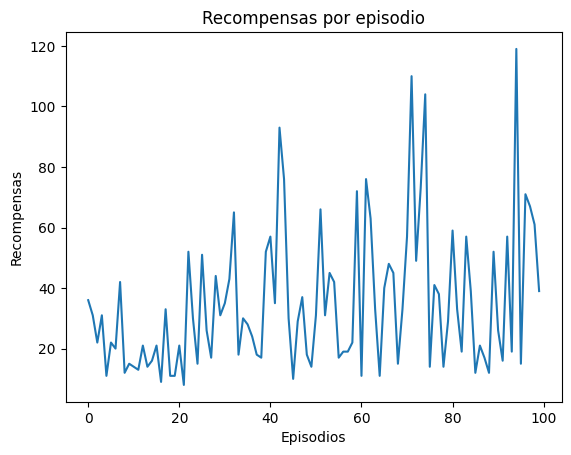

In [58]:

# Datos de ejemplo
x = [i for i in range(100)]
y =  scores  # Arreglo para el eje y (puedes cambiarlo por tus datos)


# Crear la gráfica de línea con seaborn
sns.lineplot(x=x, y=y,)

# Añadir etiquetas y título
plt.xlabel('Episodios')
plt.ylabel('Recompensas')
plt.title('Recompensas por episodio')

# Mostrar la gráfica
plt.show()
